In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# 对于tf2.0.0,（对应的cuda10.0,cudnn7.6.5），会出现running out of memory during your application的问题，因此需要加入下面的话
# tf2.1会修复此问题
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession
#config = ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.2
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

# evaluation using sklearn
from sklearn.metrics import accuracy_score,recall_score, precision_score
from sklearn.metrics import confusion_matrix

from PIL import Image
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math

from detection_data import x_trainT1, x_trainT2, y_trainT1, y_trainT2
from detection_data import x_valT1, x_valT2, y_valT1, y_valT2
from utils import label_size, modify_label_size, input_size
from detection_model import Net, num_classes

train data: 
(36358, 36, 36, 1) float32
(36064, 36, 36, 1) float32
(36358,) int64
(36064,) int64

validation data: 
(13916, 36, 36, 1) float32
(13916, 36, 36, 1) float32
(13916,) int64
(13916,) int64


In [2]:
# hyperparameters
lr = 0.0001
training_steps = 4000
batch_size = 64
display_step = 50

#steps_per_epoch = 10
#epochs = 10

In [3]:
net = Net(num_classes)

In [4]:
#net.load_weights(filepath="./segmentation_model_weights/save_model_weights_36x36.ckpt")

In [5]:
# data augmentation
def rotate(image, angle):
    sess = tf.compat.v1.Session()
    image = image.eval(session = sess)              # from tensor to array: .numpy(),但这里用.numpy()转换有点问题，用eval转换成numpy
    
    image = Image.fromarray(image)  
    rotated = Image.Image.rotate(image, angle)

    image = tf.convert_to_tensor(np.array(rotated))
    image = tf.expand_dims(image, -1)
    return image

def augmentation(image, label):
    image = tf.image.random_flip_left_right(image) # Randomly flip the image horizontally.
    image = tf.image.random_contrast(image, lower=0.8, upper=0.9)# Randomly adjust contrast and saturation.
    image = tf.image.random_brightness(image, max_delta=0.2)
    #image = tf.image.random_crop(image, (28,28,1)) 这个就可以代替自己data.py代码里面的crop
    #image = tf.keras.preprocessing.image.random_zoom(image, (0.2,0.2), row_axis=0, col_axis=1, 
                                                     #channel_axis=2, fill_mode='nearest',cval=0.0, interpolation_order=1)
    #image = tf.convert_to_tensor(tf.keras.preprocessing.image.random_rotation(image.numpy(), 20, row_axis=0, col_axis=1, 
                                                                #channel_axis=2, fill_mode='nearest', cval=0.0,interpolation_order=1))
    #image = tf.image.rot90(image, k=1)
    return image, label

In [6]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_trainT1,y_trainT1))
train_data = train_data.repeat().map(augmentation).shuffle(5000).batch(batch_size).prefetch(1)

val_data = tf.data.Dataset.from_tensor_slices((x_valT1,y_valT1))
val_data = val_data.map(augmentation).batch(batch_size).prefetch(1)

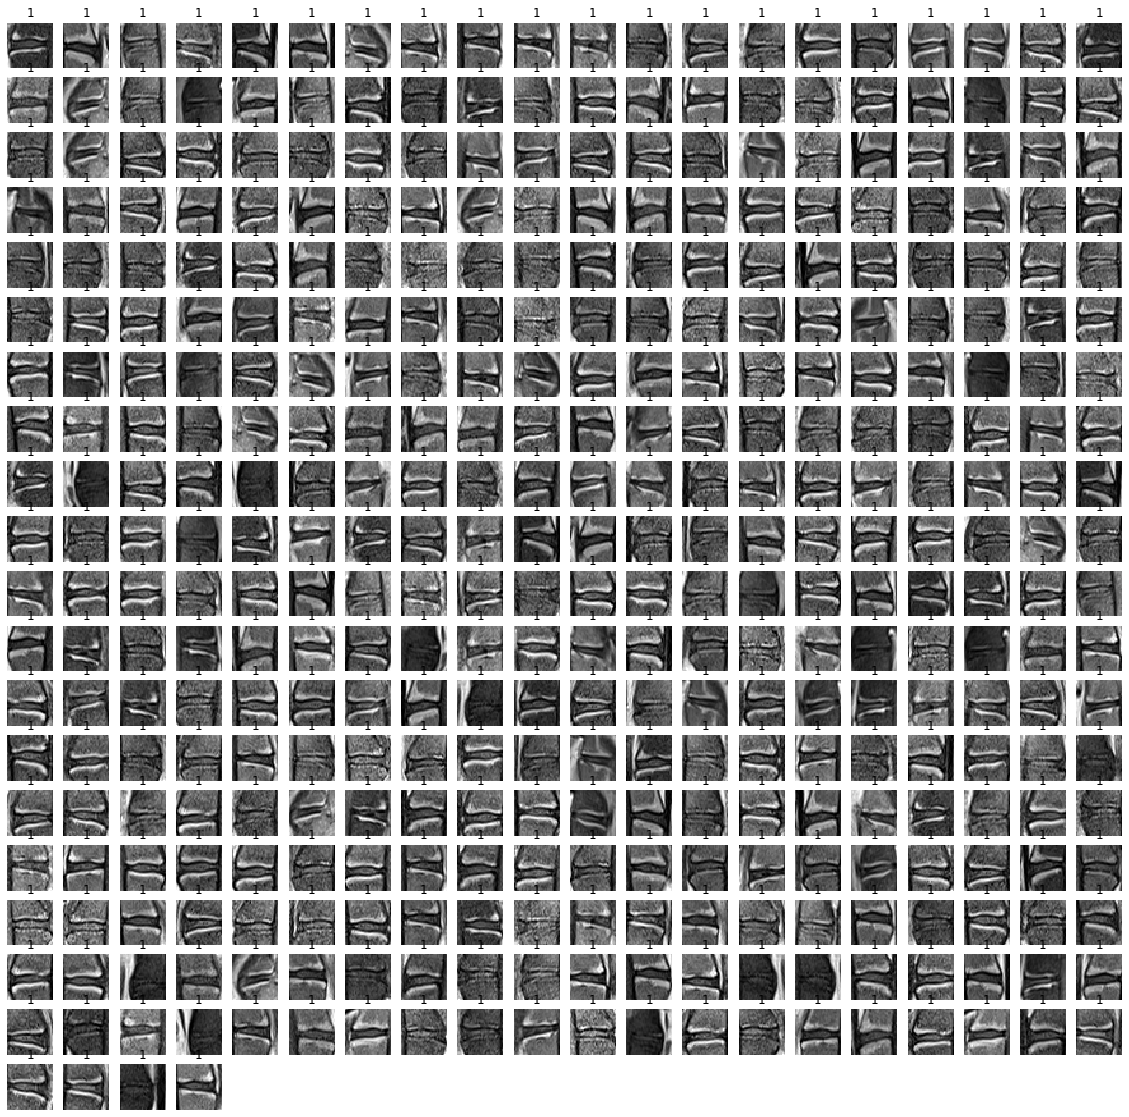

In [7]:
# visualize the train data
plt.figure(figsize = (20,20))
for i, (batch_x, batch_y) in enumerate(train_data.take(6)):
    for j, (im,im_label) in enumerate(zip(batch_x,batch_y)):
        plt.subplot(20,20,i*batch_size+j+1)
        plt.imshow(tf.squeeze(im),cmap='gray')
        plt.axis('off')
        plt.title(im_label.numpy())
plt.show()

In [8]:
# Cross-entropy loss
def cross_entropy(y_pred,y_true): # y_pred (bs,10)  y_true(bs,)
    #y_true = tf.cast(y_true,tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true)  # loss dim (bs,)
    return tf.reduce_mean(loss)

# Accuracy metric
def accuracy(y_pred,y_true):
    correction = tf.equal(tf.argmax(y_pred,axis=1),y_true)
    return tf.reduce_mean(tf.cast(correction,tf.float32))        # 必须要先转换成float32,才能呗tf.reduce_mean给计算

# Optimizer
#optimizer = tf.optimizers.Adam(lr)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)

In [9]:
# 更新lr
def lr_fn(step, base_lr=1e-4):
    if step % 2000 == 0:
        print("\nStep: {}. Reducing Learning Rate from {} to {}".format(step, base_lr, base_lr * 0.1))
        return base_lr * 0.1
    else:
        return base_lr

# optimization process
def run_optimization(step, x_train,y_train):
    with tf.GradientTape() as g:
        y_pred = net(x_train,is_training = True)  # 注意，net需要的所有参数都要传入
        loss = cross_entropy(y_pred,y_train)
    
    gradients = g.gradient(loss, net.trainable_variables)
    optimizer.learning_rate = lr_fn(step, optimizer.learning_rate.numpy())         #可以定义一个lr随epoch变化的lr_fn函数
    optimizer.apply_gradients(zip(gradients,net.trainable_variables))

In [10]:
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#train_log_dir = 'detection_logs/gradient_tape/' + current_time + '/train'
#train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [11]:
train_accs = []
train_losss = []
val_accs = []
val_losss = []

for step,(batch_x,batch_y) in enumerate(train_data.take(training_steps),start = 1):
    run_optimization(step, batch_x,batch_y)
    
    with train_summary_writer.as_default():
        y_pred = net(batch_x)
        tf.summary.scalar('loss', cross_entropy(y_pred,batch_y), step=step)
        tf.summary.scalar('accuracy', accuracy(y_pred,batch_y), step=step)

    train_accs.append(accuracy(y_pred,batch_y))
    train_losss.append(cross_entropy(y_pred,batch_y))
    
    if step%display_step == 0:
        x_val = np.zeros((x_valT1.shape[0]//batch_size * batch_size, input_size[0],input_size[1],1))
        y_pred = np.zeros((x_valT1.shape[0]//batch_size * batch_size, num_classes))
        y_val= np.zeros((x_valT1.shape[0]//batch_size * batch_size,))
        for i, (batch_x, batch_y) in enumerate(val_data.take(x_valT1.shape[0]//batch_size)):
            x_val[i*batch_size:(i+1)*batch_size] = batch_x.numpy()
            y_pred[i*batch_size:(i+1)*batch_size] = net(batch_x).numpy()
            y_val[i*batch_size:(i+1)*batch_size] = batch_y
        y_val = y_val.astype(np.int64)
        loss = cross_entropy(y_pred,y_val)
        acc = accuracy(y_pred,y_val)
        val_accs.append(acc)
        val_losss.append(loss)
        
        print("step: {:d}, loss: {:.5f}, accuracy: {:.5f}".format(step,loss,acc))

step: 50, loss: 0.69596, accuracy: 0.49899
step: 100, loss: 0.69888, accuracy: 0.49899
step: 150, loss: 0.69842, accuracy: 0.49899
step: 200, loss: 0.69422, accuracy: 0.49878
step: 250, loss: 0.69186, accuracy: 0.49662
step: 300, loss: 0.72289, accuracy: 0.49899
step: 350, loss: 0.77629, accuracy: 0.49899
step: 400, loss: 0.76873, accuracy: 0.49899
step: 450, loss: 0.71533, accuracy: 0.52815
step: 500, loss: 0.60554, accuracy: 0.67872
step: 550, loss: 0.38982, accuracy: 0.94672
step: 600, loss: 0.37276, accuracy: 0.97710
step: 650, loss: 0.36217, accuracy: 0.98769
step: 700, loss: 0.38450, accuracy: 0.98891
step: 750, loss: 0.42500, accuracy: 0.97149
step: 800, loss: 0.38361, accuracy: 0.98819
step: 850, loss: 0.32815, accuracy: 0.99093
step: 900, loss: 0.32538, accuracy: 0.99489
step: 950, loss: 0.33022, accuracy: 0.99510
step: 1000, loss: 0.34016, accuracy: 0.99194
step: 1050, loss: 0.34866, accuracy: 0.99273
step: 1100, loss: 0.33981, accuracy: 0.99474
step: 1150, loss: 0.33090, acc

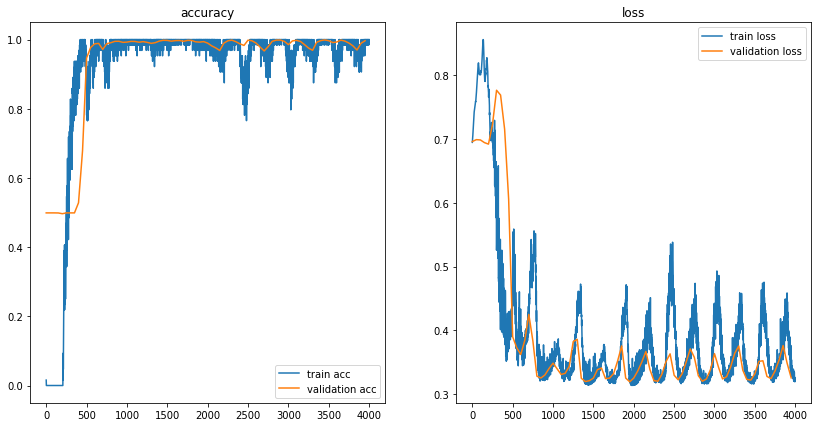

In [12]:
# draw the train and validation acc and err
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(np.arange(len(train_accs)), train_accs, label = 'train acc')
plt.plot(np.arange(len(val_accs))*display_step, val_accs, label = 'validation acc')
plt.legend()
plt.title('accuracy')

plt.subplot(122)
plt.plot(np.arange(len(train_losss)), train_losss, label = 'train loss')
plt.plot(np.arange(len(val_losss))*display_step, val_losss, label = 'validation loss')
plt.legend()
plt.title('loss')
plt.show()

In [13]:
# test model performance by using test data
x_val = np.zeros((x_valT1.shape[0]//batch_size * batch_size, input_size[0],input_size[1],1))
y_pred = np.zeros((x_valT1.shape[0]//batch_size * batch_size, num_classes))
y_val = np.zeros((x_valT1.shape[0]//batch_size * batch_size,))
for i, (batch_x, batch_y) in enumerate(val_data.take(x_valT1.shape[0]//batch_size)):
    x_val[i*batch_size:(i+1)*batch_size] = batch_x.numpy()
    y_pred[i*batch_size:(i+1)*batch_size] = net(batch_x).numpy()
    y_val[i*batch_size:(i+1)*batch_size] = batch_y.numpy()

print("accuracy: %f" % accuracy(y_pred, y_val))

accuracy: 0.996544


In [14]:
# evaluation using sklearn
# 分类准确率, 是指所有分类正确的百分比
print('accuracy_score: ',accuracy_score(y_val, np.argmax(y_pred,axis=1)))
# 召回率 = 在所有正的样本里面预测正确的比例。通俗地说，就是所有准确的条目有多少被检索出来了
print('recall_score: ',recall_score(y_val, np.argmax(y_pred,axis=1))) 
# 查准率, 指的是在所有预测正的里面正确的比例
print('precision_score: ',precision_score(y_val, np.argmax(y_pred,axis=1)))

# Confusion matrix such that Cij is equal to the number of observations known to be in group i and predicted to be in group j.
print('confusion matrix:\n', confusion_matrix(np.argmax(y_pred,axis=1), y_val, labels=range(num_classes)))

accuracy_score:  0.9965437788018433
recall_score:  1.0
precision_score:  0.9931487296602912
confusion matrix:
 [[6882    0]
 [  48 6958]]


(0,)
(48,)
draw wrong examples with label = 1 and prediction = 0


<Figure size 1440x1440 with 0 Axes>

draw wrong examples with label = 0 and prediction = 1


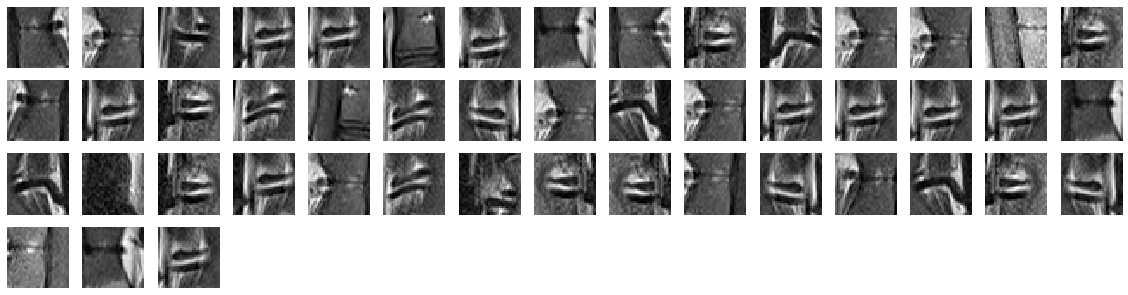

In [15]:
# find the wrong classification
wrong_10 = np.intersect1d(np.where(y_pred[:,0] > y_pred[:,1])[0], np.where(y_val == 1)[0])# predict 0 , but that is actually 1
wrong_01 = np.intersect1d(np.where(y_pred[:,0] < y_pred[:,1])[0], np.where(y_val == 0)[0])# predict 1 , but that is actually 0

print(wrong_10.shape)
print(wrong_01.shape)

print('draw wrong examples with label = 1 and prediction = 0')
plt.figure(figsize=(20,20))
for i, ind in enumerate(wrong_10):
    plt.subplot(15,15,i+1)
    plt.imshow(x_val[ind].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

print('draw wrong examples with label = 0 and prediction = 1')
plt.figure(figsize=(20,20))
for i, ind in enumerate(wrong_01):
    plt.subplot(15,15,i+1)
    plt.imshow(x_val[ind].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

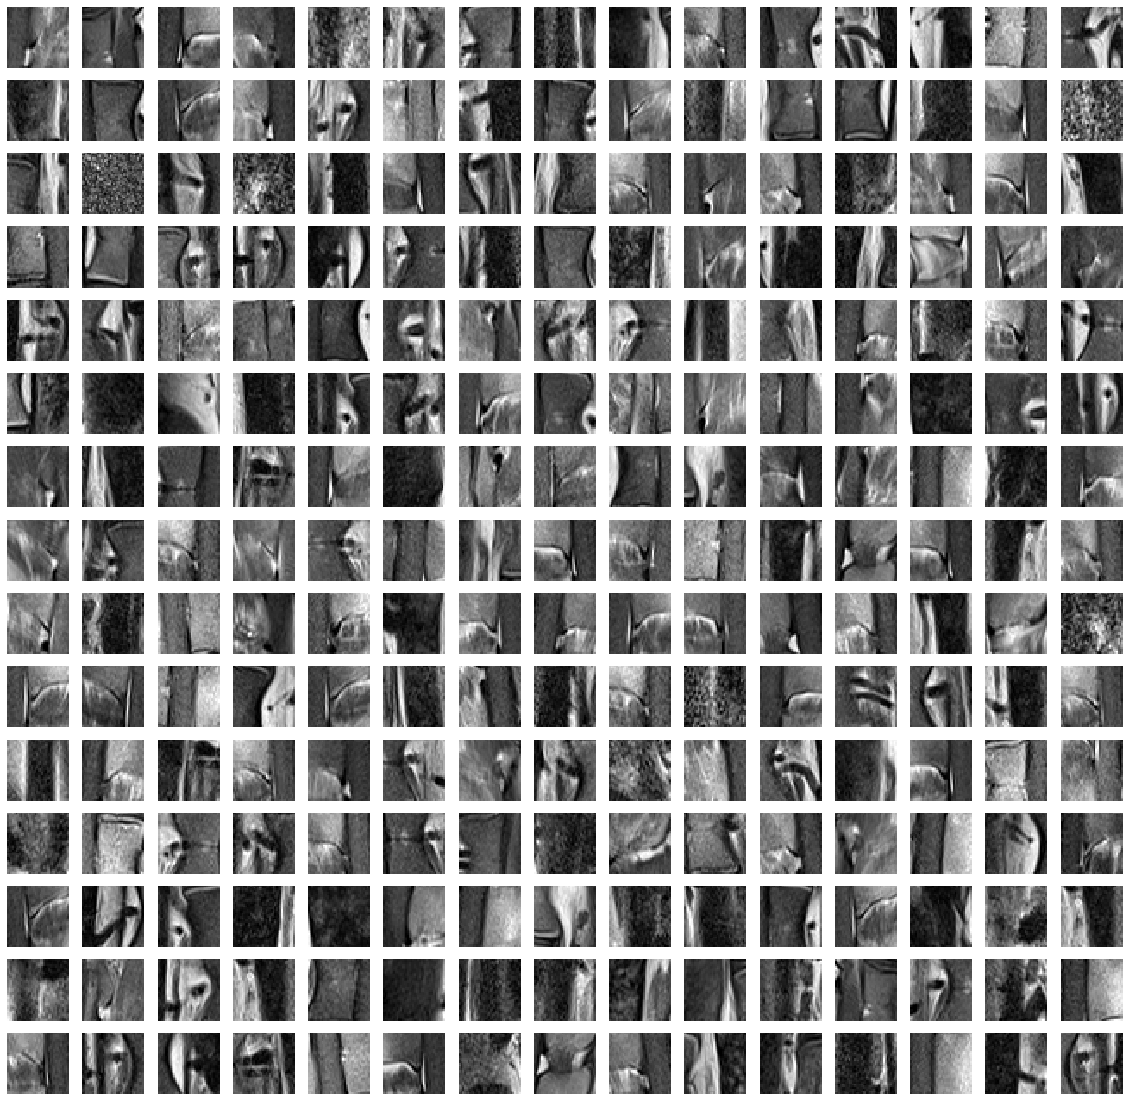

In [16]:
# draw draw true examples with label = 0 and prediction = 0
true_00 = np.intersect1d(np.where(y_pred[:,0] > y_pred[:,1])[0], np.where(y_val == 0)[0])# predict 0 , and that is actually 0

plt.figure(figsize=(20,20))
for i, ind in enumerate(true_00):
    if i == 225:
        break
    plt.subplot(15,15,i+1)
    plt.imshow(x_val[ind+1000].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

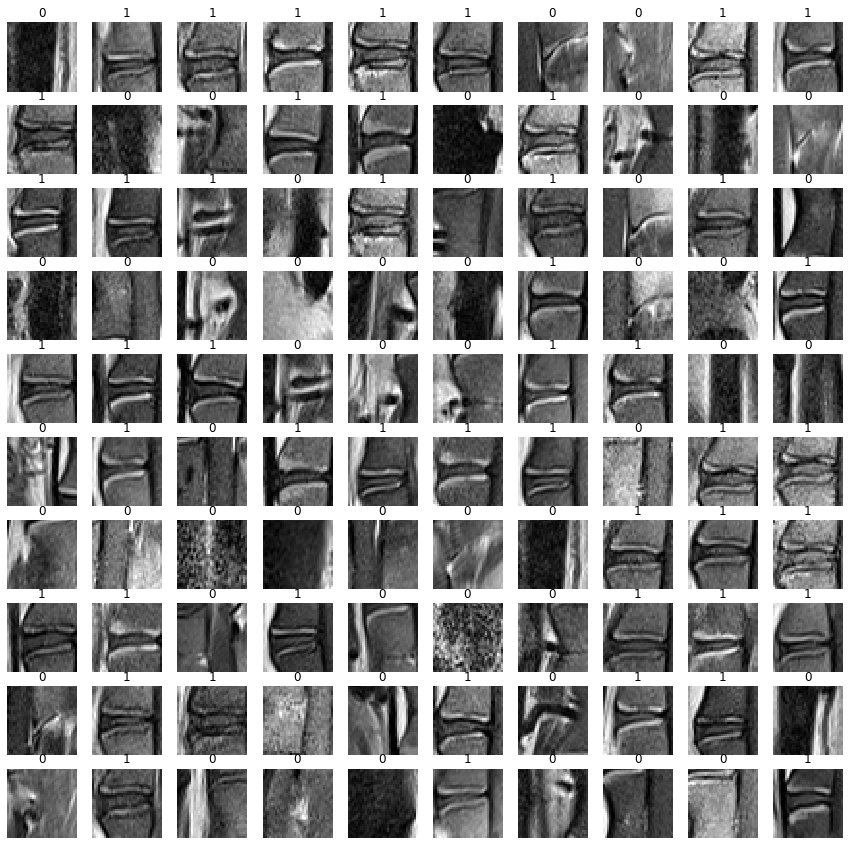

In [17]:
# draw some test data and their predictions
plt.figure(figsize=(15,15))
N = 100
for i in range(1,N+1):
    n = np.random.randint(x_valT1.shape[0])
    plt.subplot(10,10,i)
    plt.imshow(x_valT1[n].squeeze(), cmap='gray')
    plt.title(np.argmax(net(x_valT1[n][np.newaxis,:,:,:])))
    plt.axis('off')

In [18]:
#net.save_weights(filepath="./segmentation_model_weights/save_model_weights_36x36.ckpt")